# Tarea:

* Agrupar por sector (limpiar los datos)
* Entrenar una regresión Logística y encontrar los mejores hiperparámetros
* Probar cross-validation
* Graficar Precision-Recall curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

### Carga de datos

In [2]:
ipc_path = "ipc.xlsx" # Modificar a ruta
market = pd.read_excel(ipc_path, index_col=0)
market.columns = [c.replace(" MF Equity", "").replace(" INDEX", "").replace("*", "") for c in market.columns]

In [3]:
Rmkt = market.pct_change().dropna()
y = (Rmkt["MEXBOL"].pct_change() > 0).astype(int)
X = Rmkt.drop("MEXBOL", axis=1).join(y, how="inner")

y = X["MEXBOL"]
X = X.drop("MEXBOL", axis=1)
print(y.value_counts(),Rmkt.shape)

0    490
1    182
Name: MEXBOL, dtype: int64 (672, 36)


### Carga de archivo con agrupaciones

In [5]:
emi = pd.DataFrame(X.columns).set_index(0)
ref = pd.read_csv("bmv_emisoras.csv", index_col=0,encoding="utf-8")
ref.drop(['Teléfono','Relación con Inversionistas','Actividad Economica','E-mail', 'Fax', 'Fecha de Constitución', 'Fecha de listado en BMV','Historia de la Empresa','Oficinas Corporativas','Principales Productos y/o Servicios'],axis=1,inplace=True)
emisoras = emi.join(ref, how='inner')

<h3 style="color:Tomato;">Agrupación por sector</h1>

In [6]:
#X2 = X.groupby(emisoras["Ramo"],axis = 1).mean()
X = X.groupby(emisoras['Sector'],axis = 1).mean()
#X2 = X.groupby(emisoras['Subramo'],axis = 1).mean()
#X2 = X.groupby(emisoras['Subsector'],axis = 1).mean()

X.head()

Sector,ENERGÍA,INDUSTRIAL,MATERIALES,PRODUCTOS DE CONSUMO FRECUENTE,SALUD,SERVICIOS DE TELECOMUNICACIONES,SERVICIOS FINANCIEROS,SERVICIOS Y BIENES DE CONSUMO NO BÁSICO
DATE,,,,,,,,
2017-06-08,-0.000341,0.000439,0.004354,-0.006015,0.006852,-0.005709,-0.000570,0.007945
2017-06-09,0.001708,-0.003777,0.011521,-0.006060,-0.008082,-0.001745,-0.004182,0.016661
2017-06-12,0.004319,0.002034,-0.006207,0.004485,-0.011578,0.003777,0.004639,0.009951
2017-06-13,0.039040,0.008069,-0.002084,-0.006677,-0.003905,-0.004019,-0.000636,0.000536
2017-06-14,0.028861,0.011743,0.003354,0.003949,0.001307,0.001642,0.011262,0.000853


### Generar Train y test

In [21]:
train_period = "2019-06"
test_period = "2019-07"
Xtrain, ytrain = X[:train_period], y[:train_period]
Xtest, ytest = X[test_period:], y[test_period:]

In [22]:
print(y.value_counts())
print(ytrain.value_counts())
print(ytest.value_counts())

0    490
1    182
Name: MEXBOL, dtype: int64
0    391
1    146
Name: MEXBOL, dtype: int64
0    99
1    36
Name: MEXBOL, dtype: int64


In [23]:
print(y.shape)
print(ytrain.shape)
print(ytest.shape)

(672,)
(537,)
(135,)


### Modelo

In [27]:
# paso 1: importar el modelo
from sklearn.linear_model import LogisticRegression
# paso 2: inicializar el modelo (con sus hiperparámetros)
model = LogisticRegression()



In [28]:
# paso 3: "entrenar" el modelo
#Pipe
pipe = Pipeline([
    ("poly", PolynomialFeatures()),
    ("model",LogisticRegression())
])

In [29]:
#Grid
Cs = np.linspace(0.,1,21)[1:]
params = {
    "model__solver": ['newton-cg', 'sag', 'saga' ,'lbfgs'],
    "model__warm_start":[True,False],
    "model__C": Cs,
    "poly__degree":[1,2,3],
    "poly__include_bias":[True,False]
}
gcv = GridSearchCV(pipe, params, scoring="r2",cv=5)


In [30]:
gcv.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('model',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                        

<h3 style="color:Tomato;">mejores parámetros</h1>

In [31]:
gcv.best_params_

{'model__C': 0.05,
 'model__solver': 'newton-cg',
 'model__warm_start': True,
 'poly__degree': 1,
 'poly__include_bias': True}

<h3 style="color:Tomato;">cross validation</h1>

In [82]:
res = cross_validate(gcv,Xtrain,ytrain,scoring="accuracy",cv=5)
res["test_score"].mean()

0.7281316985338249

<h3 style="color:Tomato;">Precision-Recall curve</h1>

In [34]:
yhat = gcv.predict(Xtest)
cm = confusion_matrix(ytest, yhat, labels=[0, 1])
cm

array([[99,  0],
       [36,  0]], dtype=int64)

Text(0.5, 0, 'Nivel de proba asignada')

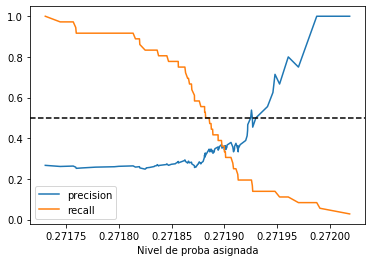

In [78]:
proba_estimate = gcv.predict_proba(Xtest)[:, 1]
prec, recall, threshold = precision_recall_curve(ytest, proba_estimate)

plt.plot(threshold, prec[:-1], label="precision")
plt.plot(threshold, recall[:-1], label="recall")
plt.legend()
#plt.axvline(x=0.5, linestyle="--", c="black")
plt.axhline(y=0.5, linestyle="--", c="black")
plt.xlabel("Nivel de proba asignada")

### curva ROC

In [64]:
probs = gcv.predict_proba(Xtest)
prob = probs[:,1]

prob_df = pd.DataFrame(prob)

threshold = 0.5

prob_df["pred_thr"] = np.where(prob_df[0]>threshold, 1, 0)
prob_df["actual"] = list(ytest)
prob_df["pred_mod"] = list(yhat)
prob_df.rename(columns={0: "prob"},inplace=True)

In [67]:
prob_df.prob.min(),prob_df.prob.max()


(0.27173014926606387, 0.2720188649442299)

In [79]:
thresholds = np.linspace(0.,1,1000)

sensitivities = []
especifities_1 = []

for t in thresholds:
    prob_df["pred_thr"] = np.where(prob_df['prob']>=t,1,0)
    prob_df["actual"] = list(ytest)
    prob_df.head()

    conf_m = confusion_matrix(prob_df["actual"], prob_df["pred_thr"], labels=[0, 1])

    TP2 = conf_m[0,0]
    FP2 = conf_m[1,0]
    TN2 = conf_m[0,1]
    FN2 = conf_m[1,1]
    
    Pre2 = (TP2/(TP2+FP2))
    Rec2 = (TP2/(TP2+FN2))
    F12 = (2/(1/Rec2+1/Pre2))
    sens2 = TP2/(TP2+FN2)
    sensitivities.append(sens2)
    espc_12 = 1-(TN2/(TN2+FP2))
    especifities_1.append(espc_12)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

invalid value encountered in longlong_scalars

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

divide by zero encountered in double_scalars



In [80]:
ex,sx,_ = roc_curve(ytest,prob)

Text(0.5, 1.0, 'cruva ROC')

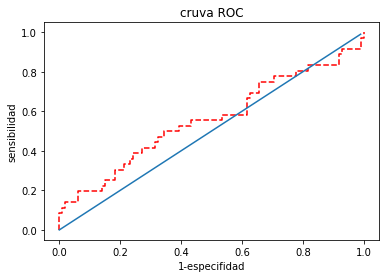

In [81]:
plt.plot(ex, sx,linestyle='--',color='r')
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-especifidad")
plt.ylabel("sensibilidad")
plt.title("curva ROC")